In [1]:
from keras.models  import load_model
import keras.backend as K

import cPickle
import sys
sys.path.insert(0, '../../preprocess')
import vectorizer

from sklearn.preprocessing import normalize
import pandas as pd
import numpy as np

aspects = ['population', 'intervention', 'outcome']
aspects = [a[0].upper() for a in aspects]

Using TensorFlow backend.


[]


In [2]:
vec = cPickle.load(open('../data/vectorizers/allfields_with_embedding_5000.p', 'rb'))

In [3]:
da = pd.read_csv('../data/files/decision_aids_filter.csv')
im_map = {'breast cancer': 'BCT', 
          'healthy women at risk of breast cancer': 'BCS', 
          'type II diabetes': 'D',
          'menopausal women': 'MW',
          'pregnant women, previous C section': 'PWC',
          'pregnant women': 'PW',
          'healthy people, at risk colon cancer': 'CCS',
          'prostate cancer': 'PCT',
          'healthy men, contemplating risk of prostate cancer': 'PCS',
          'AF': 'AF',
          'healthy women at genetic risk of breast cancer': 'BCG'}

In [4]:
davec = cPickle.load(open('../data/vectorizers/decision_aids_vec_5000.p'))

In [5]:
file_model = '../store/weights/single_setup/SatDec216:57:342017final1/loss.h5'
model = load_model(file_model, custom_objects={'contrastive_loss' : lambda a,b : a, '<lambda>' : lambda a,b : a})

In [6]:
model_aspect = {}
for aspect in aspects :
    model_aspect[aspect] = K.function(model.get_layer('pool_'+aspect).inputs + [K.learning_phase()], 
                          [model.get_layer('pool_'+aspect).outputs[0]])

In [7]:
pool_da = {}
norm_pool_da = {}

for aspect in aspects :
    pool_da[aspect] = model_aspect[aspect]([davec.X, 0])[0]
    norm_pool_da[aspect] = normalize(np.float64(pool_da[aspect]))
concat = np.concatenate(norm_pool_da.values(), axis=1)

In [8]:
irange = vec.index['abstract']
X_abs = vec.X[irange[0]:irange[1]]
pool_cdsr = {}
norm_pool_cdsr = {}

for aspect in aspects :
    pool_cdsr[aspect] = []
    for i in range(int(np.floor(len(X_abs)/500))) :
        pool_cdsr[aspect].append(model_aspect[aspect]([X_abs[i*1000:(i+1)*1000,:], 0])[0])
    pool_cdsr[aspect] = np.concatenate(pool_cdsr[aspect])
    norm_pool_cdsr[aspect] = normalize(np.float64(pool_cdsr[aspect]))
    
#concat = np.concatenate(norm_pool_cdsr.values())

In [9]:
from sklearn.decomposition import PCA, KernelPCA, TruncatedSVD
from sklearn.manifold import TSNE, MDS
from sklearn.preprocessing import StandardScaler
pca_models = {}
for aspect in aspects :
    pca = PCA(n_components=2, svd_solver='arpack', tol=0.0000001)
    #data = np.concatenate([norm_pool_cdsr[aspect], norm_pool_da[aspect]], axis=0)
    data = norm_pool_cdsr[aspect]
    pca.fit(data)
    pca_models[aspect] = pca
    
pcas = {}
for aspect in aspects :
    pcas[aspect] = pca_models[aspect].transform(norm_pool_da[aspect])

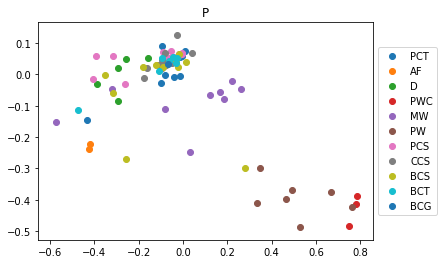

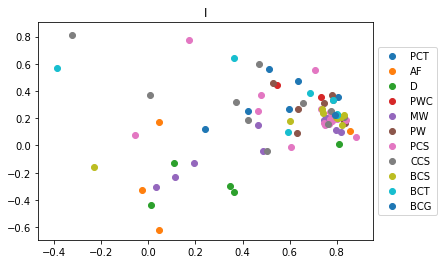

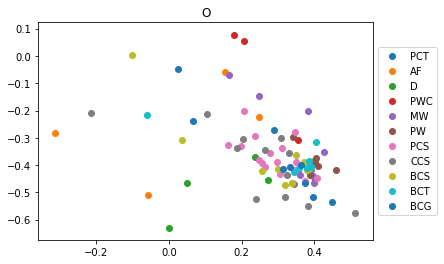

In [10]:
#PCA

for aspect in aspects :
    import matplotlib.pyplot as plt
    for key in im_map.keys() :
        idxs = da[da['IM_population'] == key].index
        plt.scatter(pcas[aspect][idxs, 0], pcas[aspect][idxs, 1], label=im_map[key])
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(aspect)
    plt.savefig('../store/pca_DA_'+aspect+'.pdf', format='pdf',bbox_inches='tight')
    plt.show()

In [37]:
tsnes = {}
for aspect in aspects :
    tsnes[aspect] = TSNE(n_components=2, method='exact', verbose=1).fit_transform(norm_pool_da[aspect])

[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 87 / 87
[t-SNE] Mean sigma: 0.171949
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.536219
[t-SNE] Error after 1000 iterations: 0.213569
[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 87 / 87
[t-SNE] Mean sigma: 0.181166
[t-SNE] KL divergence after 250 iterations with early exaggeration: 53.405370
[t-SNE] Error after 950 iterations: 0.135861
[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 87 / 87
[t-SNE] Mean sigma: 0.208377
[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.919014
[t-SNE] Error after 1000 iterations: 0.413037


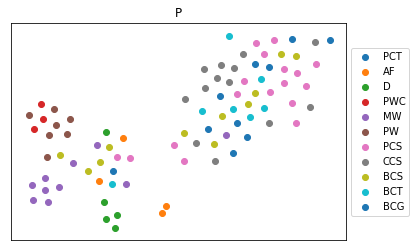

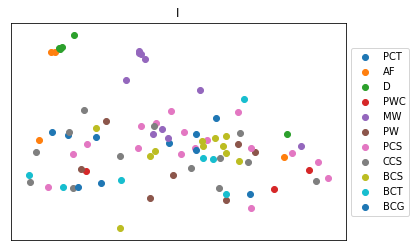

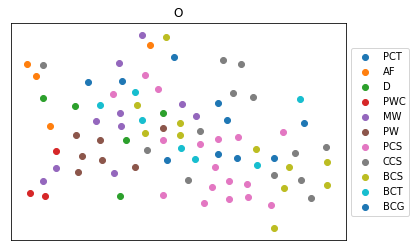

In [38]:
import matplotlib.pyplot as plt
for aspect in aspects :
    for key in im_map.keys() :
        idxs = da[da['IM_population'] == key].index
        plt.scatter(tsnes[aspect][idxs, 0], tsnes[aspect][idxs, 1], label=im_map[key])
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(aspect)
    plt.xticks([])
    plt.yticks([])
    #plt.savefig('../store/tsne_DA_'+aspect+'.pdf', format='pdf',bbox_inches='tight')
    plt.show()

In [14]:
nb_studies = len(da)
H = np.zeros((nb_studies, nb_studies))
for i in range(nb_studies) :
    H[i, da[da['IM_population'] == da['IM_population'][i]].index] = 1
np.fill_diagonal(H, 0)

scores = {}
for aspect in aspects :
    scores[aspect] = np.clip(np.dot(norm_pool_da[aspect], norm_pool_da[aspect].T), a_max=1., a_min=None)
    np.fill_diagonal(scores[aspect], -1000)
scores['tot'] = np.dot(concat, concat.T)
np.fill_diagonal(scores['tot'], -1000)


In [ ]:
from sklearn.metrics import roc_auc_score
series = {}
for aspect in aspects + ['tot'] :
    aucs = [0] * nb_studies
    for i in range(nb_studies) :
        aucs[i] = roc_auc_score(H[i], scores[aspect][i])
    rocs = {}
    for key in im_map :
        idxs = da[da['IM_population'] == key].index
        rocs[key] = np.mean(np.array(aucs)[idxs])
    rocs['mean'] = np.mean(aucs)
    series[aspect] = pd.Series(rocs, name=aspect)
pd.DataFrame(series.values())

In [ ]:
concat.shape

In [ ]:
normalize(pool_da['P'], return_norm=True)

In [ ]:
cov = np.cov(data.T)

In [ ]:
ev , eig = np.linalg.eigh(cov)